# Crop cycles

This notebook illustrates how to use the `chunk_onnx` workflow to run time-series analysis over raster images (in parallel). Specifically, here we count the number of crop cycles in a year a certain region has. However, one can define other time analysis as long as that can be defined as an Onnx model. 

### Conda environment setup
Before running this notebook, let's build a conda environment. If you do not have conda installed, please follow the instructions from [Conda User Guide](https://docs.conda.io/projects/conda/en/latest/user-guide/index.html). 

```
$ conda env create -f ./env.yaml
$ conda activate crop_cycles
```

### Notebook outline
Here, we run SpaceEye to get cloud-free images for the specified region over one year (2018 in this example), for a total of 365 images. We then compute NDVI and perform a Fourier analysis of this signal. The rationale here is that we can describe the agricultural cycles (from emergence to harvest) using low frequency sinusoids. We then count the number of cycles and that will correspond to the number of cycles in a year.

*Notice that this notebook may take many hours to run depending on your environment and requires at least 500GB*

In [1]:
from datetime import datetime

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rio
import tensorflow as tf
import tf2onnx
import yaml
from shapely import wkt

from vibe_core.client import get_default_vibe_client

2022-12-06 16:08:04.502636: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Declare a TensorFlow model with the Fourier analysis code and save that to an Onnx file.

In [2]:
class CountCycles(tf.keras.Model):
  def __init__(self, nsamples):
    super(CountCycles, self).__init__()
    self.nsamples = nsamples

  def call(self, x):
    '''
    input and output dimentions are batch, band, y, x
    '''
    # move time (band) to the inner dimension
    x = tf.transpose(x, perm=[0,2,3,1])
    xhat = tf.signal.rfft(x - tf.math.reduce_mean(x, axis=3, keepdims=True), fft_length=[self.nsamples])
    # get the frequency with the highest amplitude
    res = tf.argsort(tf.abs(xhat), axis=3, direction="DESCENDING")[:,:,:,:1]
    # put band/frequency in the second dimension
    return tf.transpose(res, perm=[0,3,1,2])

In [3]:
N = 365  # number of days/samples in the signal
model = CountCycles(N)

spec = (tf.TensorSpec((None, N, None, None), tf.float32, name="input"),)
_ = tf2onnx.convert.from_keras(model, output_path="count_cycles.onnx", input_signature=spec)

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


2022-12-06 16:08:07.705763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 16:08:07.842100: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-12-06 16:08:07.842311: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-12-06 16:08:07.864767: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-12-06 16:08:07.864923: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new sess

Add Onnx model to FarmVibes.AI:

In [4]:
!../../farmvibes-ai.sh add-onnx ./count_cycles.onnx

We need to define a custom workflow to (1) run SpaceEye to obtain one year of cloud-free images, (2) compute NDVI, and (3) run our `CountCycles` model.

This workflow will receive three parameters:
- `pc_key`: an optional Planetary Computer API key
- `model_file`: the ONNX model file that we added to FarmVibes.AI
- `step`: the step/window size (in pixels) over which we will run our `CountCycles` model. In case the input geometry yields small rasters, consider decreasing the `step` parameter. 

We have already written a yaml file with these steps in `crop_cycles.yaml`.

In [1]:
!cat crop_cycles.yaml

name: crop_cycles
sources:
  user_input:
    - spaceeye.user_input
sinks:
  cycles: chunk_onnx.raster
parameters:
  pc_key:
  model_file: count_cycles.onnx
  step: 100
tasks:
  spaceeye:
    workflow: data_ingestion/spaceeye/spaceeye_interpolation
    parameters:
      pc_key: "@from(pc_key)"
  ndvi:
    workflow: data_processing/index/index
    parameters:
      index: ndvi
  chunk_onnx:
    workflow: data_processing/chunk_onnx/chunk_onnx
    parameters:
      model_file: "@from(model_file)"
      step: "@from(step)"
edges:
  - origin: spaceeye.raster
    destination:
      - ndvi.raster
  - origin: ndvi.index_raster
    destination:
      - chunk_onnx.rasters


In [6]:
# Load our workflow definition in the YAML file into a dict
with open("crop_cycles.yaml") as f:
    wf_dict = yaml.safe_load(f)

We also need to specify the period (in this case 2018) and the region (here an area in Portugal):

In [7]:
time_range = (datetime(2018, 1, 1), datetime(2018, 12, 31))
geometry = wkt.loads(
    "Polygon ((-8.47931009699438576 37.86536075375328636,"
    " -8.19134459346971688 37.86536075375328636,"
    " -8.19134459346971688 38.05647717029316368,"
    " -8.47931009699438576 38.05647717029316368,"
    " -8.47931009699438576 37.86536075375328636))"
)

Run the workflow:

In [8]:
client = get_default_vibe_client()

# Submit a run request by sending the worflow dictionary
run = client.run(wf_dict, "Crop cycles", geometry=geometry, time_range=time_range)

In [ ]:
run.monitor()

Load results into a `DataArray`:

In [10]:
da = rio.open_rasterio(run.output["cycles"][0].raster_asset.path_or_url)

Finally, plot results. Notice that we are considering high-frequencies as perennial. That is because perennial crops will have a flat NDVI signal and (high-frequency) noise will dominate the Fourier analysis.

Text(0.5, 0.98, 'Number of growing cycles')

<Figure size 1400x800 with 0 Axes>

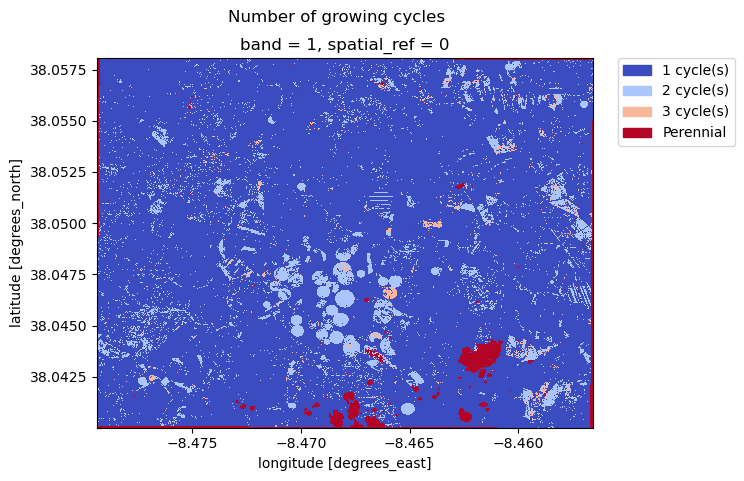

In [11]:
MAX_FREQ = 4

plt.figure(figsize=(14,8))
fig, ax = plt.subplots()

cmap = matplotlib.cm.get_cmap('coolwarm', MAX_FREQ)
im = da[0].rio.reproject("EPSG:4326").plot.imshow(ax=ax, vmax=MAX_FREQ, cmap=cmap, add_colorbar=False)
values=range(1,MAX_FREQ+1)
colors = [ im.cmap(im.norm(value)) for value in values]
labels  = [f"{i} cycle(s)" for i in values[:-1]] + ["Perennial"]
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.suptitle("Number of growing cycles")